### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Datasets Load + DataFrames build

In [2]:
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Adding names of classes from dataset Fashion MNIST description:

In [3]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Data Visualization Methods

In [4]:
histories = {}

In [5]:
def visualize_mnist_items():
    indices = np.random.choice(len(X_train), 6, replace=False)

    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(X_train[idx], cmap="gray")
        plt.title(class_names[y_train[idx]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


def visualize_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    ax[0].plot(history.history["loss"], color="g", label="Training Loss")
    ax[0].plot(history.history["val_loss"], color="b", label="Validation Loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[0].grid()
    
    ax[1].plot(history.history["accuracy"], color="g", label="Training Accuracy")
    ax[1].plot(history.history["val_accuracy"], color="r", label="Validation Accuracy")
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    ax[1].grid()
    
    plt.tight_layout()
    plt.show()


def visualize_predictions_color(model, X, y_true, class_names, num_images=10):
    y_pred_probs = model.predict(X)  
    y_pred = np.argmax(y_pred_probs, axis=1)      
    y_true_classes = np.argmax(y_true[:num_images], axis=1)  
    rows = num_images//5
    cols = 5

    plt.figure(figsize=(10, 1.5*rows))
    for i in range(num_images):
        if y_pred[i] == y_true_classes[i]:
            color = "green"
        else:
            color = "red"

        plt.subplot(rows, cols, i + 1)
        plt.imshow(X[i], cmap=f"{color}s".capitalize())
        plt.axis("off")
        plt.title(f"{class_names[y_pred[i]]}", color=color)

    accuracy = np.sum(y_pred == y_true_classes) / num_images * 100
    plt.suptitle(f"Accuracy of selection: {accuracy:.2f}%", y=-0.1)
    plt.tight_layout()
    plt.show()


def plot_combined_bars(histories):
    metrics = ["accuracy", "val_accuracy", "loss", "val_loss"]
    metric_labels = ["Train Accuracy", "Val Accuracy", "Train Loss", "Val Loss"]
    colors = ["#3498db", "#e74c3c", "#2ecc71", "#9b59b6"] 

    model_names = list(histories.keys())
    final_values = {metric: [] for metric in metrics}
    
    for model_name, history in histories.items():
        for metric in metrics:
            final_values[metric].append(history.history[metric][-1]) 
    
    x = np.arange(len(model_names)) 
    width = 0.15 
    
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, metric in enumerate(metrics):
        offset = i * width - (1.5 * width) 
        values = final_values[metric]
        bars = ax.bar(x + offset, values, width, label=metric_labels[i], color=colors[i])
        
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{height:.2f}", 
                        xy=(bar.get_x() + bar.get_width() / 2, height), 
                        xytext=(0, 3),  
                        textcoords="offset points", 
                        ha="center", va="bottom")

    ax.set_title("Final Metrics Comparison for All Models")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_ylabel("Metric Values")
    ax.set_ylim(0, max(max(values) for values in final_values.values()) * 1.2)
    ax.legend(title="Metrics", loc="upper right")

    plt.tight_layout()
    plt.show()


### Data Info & Data Preparation

- **Step 1.** Random images from dataset overview:

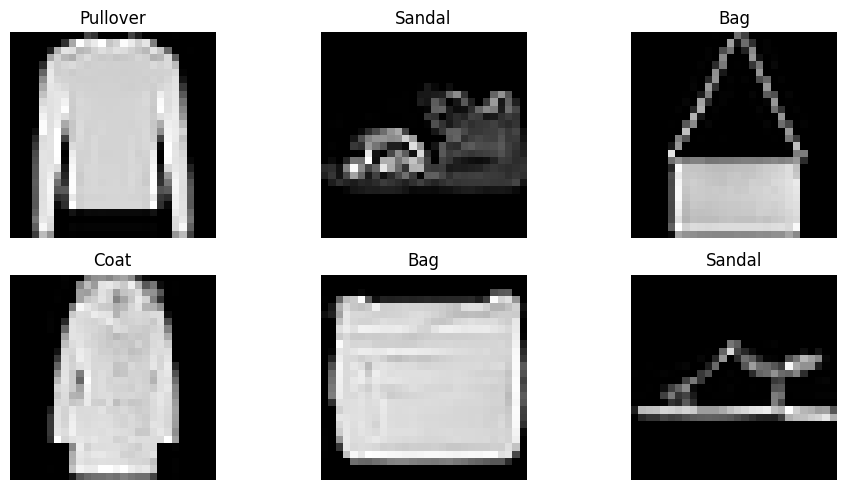

In [6]:
visualize_mnist_items()

- **Step 2.** Images normalization: Scaling images to the range [0, 1] :

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

- **Step 3.** Check the shapes of the training and test datasets:

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

It"s clearly seen that there are 60,000 training images and 10,000 test images, each with a size of 28x28 pixels. The labels (y_train and y_test) indicate the corresponding class for each image.

- **Step 4.** Adding an extra dimension to the image arrays, which is necessary for compatibility with convolutional layers (Conv2D):

In [9]:
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

- **Step 5.** Converting labels for **One-Hot Encoding**. This is necessary for using `categorical_crossentropy` as the loss function:

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Basic CNN Model

- **Step 1.** Defining the Task for better CNN model architecture:

Taking into account that the task for the CNN on the fashion MNIST dataset is a *multi-class, single-label classification problem*, I will use Softmax as an activation function for the last layer. It converts the output of the neurons into a probability distribution where the sum of all probabilities is equal to 1. This is ideal for multi-class, single-label classification as it will allow the model to assign a probability to each class and select the one with the highest probability as the prediction.

As the loss function I will use *Categorical cross-entropy* because it"s specifically designed for multi-class classification tasks and will allow the model to learn by minimizing the difference between the predicted probabilities and the true class labels.

- **Step 2.** Creating and compiling Convolutional neural network model with the following architecture:

- **Layers**: 9 layers in total (3 Conv2D, 3 MaxPooling2D, 1 Flatten, 1 Dense, 1 Dropout, 1 Output).
- **Activation Functions**: ReLU for hidden layers, Softmax for the output layer.
- **Loss Function**: Categorical Crossentropy.
- **Optimizer**: Adam.
- **Metrics**: Accuracy.

In [11]:
model_v1 = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")],
    name="V1_32_64_128")

model_v1.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model_v1.summary()

Model: "V1_32_64_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

- **Step 3.** Training the model. I"ll use 10 epochs, batch size 32 and splitting the training data into training (80%) and validation (20%): 

In [12]:
history_v1 = model_v1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


I0000 00:00:1733829498.902755      83 service.cc:145] XLA service 0x7f55fc004dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733829498.902820      83 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  62/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2452 - loss: 2.0679

I0000 00:00:1733829502.999810      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6417 - loss: 0.9761 - val_accuracy: 0.8213 - val_loss: 0.4854
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8213 - loss: 0.5006 - val_accuracy: 0.8498 - val_loss: 0.4133
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8490 - loss: 0.4208 - val_accuracy: 0.8666 - val_loss: 0.3671
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8672 - loss: 0.3710 - val_accuracy: 0.8672 - val_loss: 0.3629
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8780 - loss: 0.3377 - val_accuracy: 0.8773 - val_loss: 0.3322
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8870 - loss: 0.3118 - val_accuracy: 0.8724 - val_loss: 0.3465
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8969 - loss: 0.2833 - val_accuracy: 0.8848 - val_loss: 0.3063
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9024 - loss: 0.2670 - val_accura

- **Step 4.** Evaluating the model progress in Validation Loss and Validation Accuracy, which tracks the capability of model to generalize to unseen data:

In [13]:
test_loss, test_acc = model_v1.evaluate(X_test, y_test)
print(f"\nValidation Accuracy of the model '{model_v1.name}' : {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8903 - loss: 0.3201

Validation Accuracy of the model 'V1_32_64_128' : 0.8905


- **Step 5.** Visualizing the training history:

In [14]:
histories[model_v1.name] = history_v1

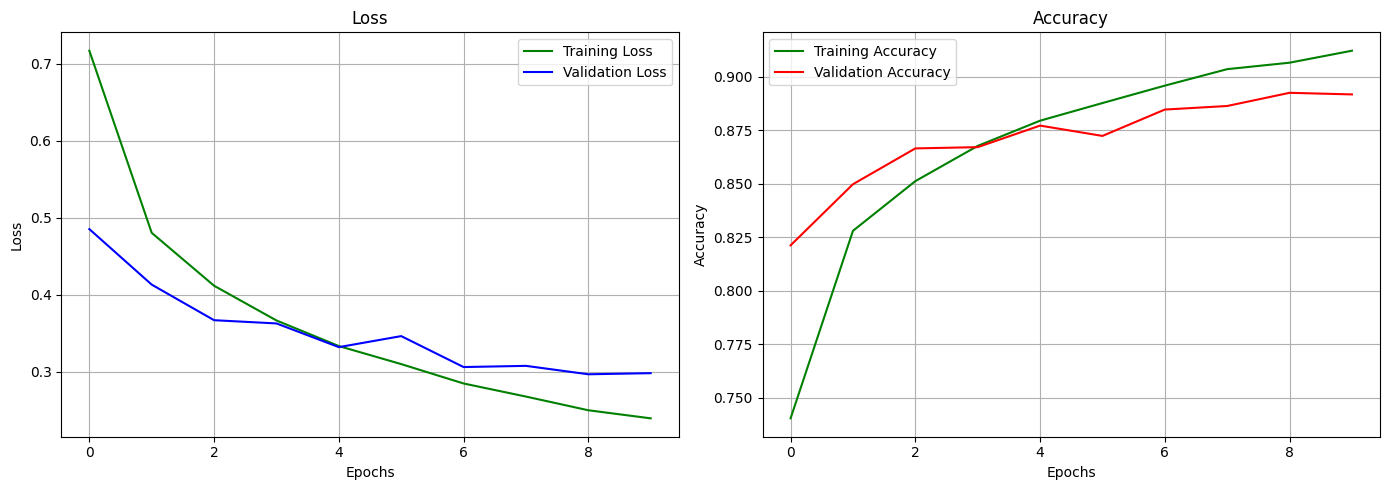

In [15]:
visualize_training_history(history_v1)

Despite the progressive improvement, the Basic model shows quite a low results on testing data. 
Th it"s why  it"s necessary here to optimazarchitecture and e hyperparamete of the model.s.

# Optimized Basic CNN Model

- **Step 1.** Using the `model_v1` as a base, I will use less hidden layers to optimize the architecture:

- **Layers**: 8 layers in total (3 Conv2D, 2 MaxPooling2D, 1 Flatten, 1 Dense, 1 Dropout, 1 Output).
- **Activation Functions**: ReLU for hidden layers, Softmax for the output layer.
- **Loss Function**: Categorical Crossentropy.
- **Optimizer**: Adam.
- **Metrics**: Accur

Creating and compiling Convolutional Neural Network model with the optimized architecture:acy.

In [16]:
model_v2 = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")],
    name="V2_32_64_64")


model_v2.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model_v2.summary()


Model: "V2_32_64_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

- **Step 2.** Training the model. I"ll use 9 epochs, batch size 32 and splitting the training data into training (80%) and validation (20%): 

In [17]:
history_v2 = model_v2.fit(X_train, y_train, epochs=9, batch_size=32, validation_split=0.2)

Epoch 1/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6674 - loss: 0.9309 - val_accuracy: 0.8599 - val_loss: 0.3990
Epoch 2/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8425 - loss: 0.4416 - val_accuracy: 0.8789 - val_loss: 0.3298
Epoch 3/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8724 - loss: 0.3738 - val_accuracy: 0.8889 - val_loss: 0.2977
Epoch 4/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8841 - loss: 0.3294 - val_accuracy: 0.8925 - val_loss: 0.2917
Epoch 5/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8947 - loss: 0.3039 - val_accuracy: 0.8997 - val_loss: 0.2828
Epoch 6/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9001 - loss: 0.2739 - val_accuracy: 0.8988 - val_loss: 0.2698
Epoch 7/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9087 - loss: 0.2568 - val_accuracy: 0.9030 - val_loss: 0.2635
Epoch 8/9
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9136 - loss: 0.2404 - val_accu

- **Step 3.** Evaluating the model progress in Validation Loss and Validation Accuracy, which tracks the capability of model to generalize to unseen data:

In [18]:
test_loss, test_acc = model_v2.evaluate(X_test, y_test)
print(f"\nValidation Accuracy of the model '{model_v2.name}' : {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9056 - loss: 0.2878

Validation Accuracy of the model 'V2_32_64_64' : 0.9037


- **Step 4.** Visualizing the training history:

In [19]:
histories[model_v2.name] = history_v2

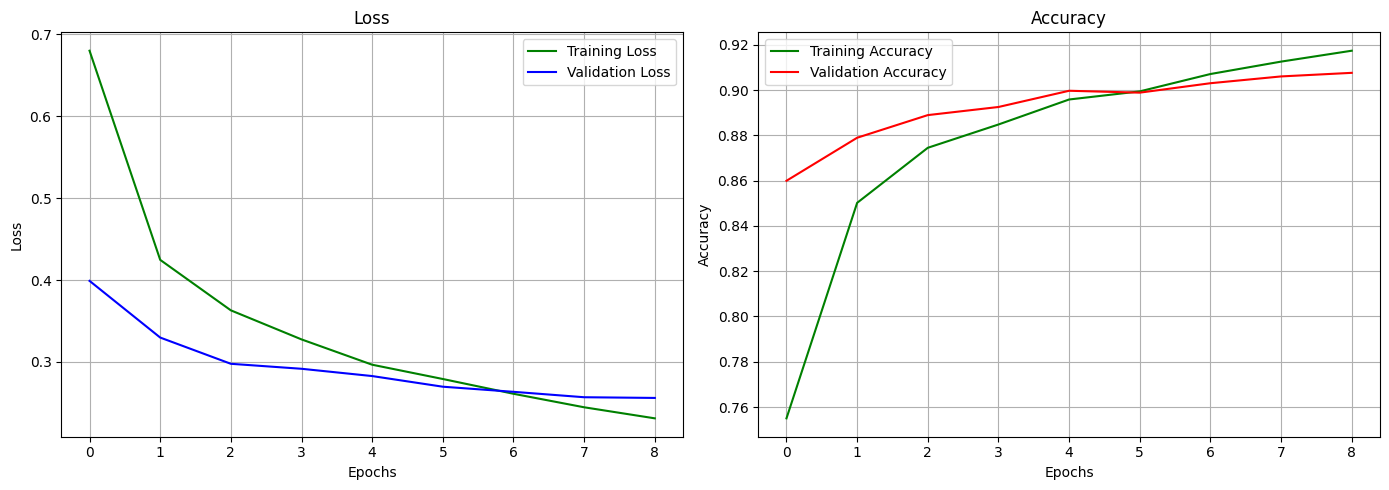

In [20]:
visualize_training_history(history_v2)

# Deep CNN Model

- **Step 1.** Creating Deep Convolutional Neural Network model with Multiple Convolutional Blocks: 

In [21]:
model_v3 = models.Sequential([
    layers.Input(shape=(28, 28, 1)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(10, activation="softmax")],
    name="V3_Conv_Blocks_3")


model_v3.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model_v3.summary()


Model: "V3_Conv_Blocks_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 619,114 (2.36 MB)

 Trainable params: 617,450 (2.36 MB)

 Non-trainable params: 1,664 (6.50 KB)

- **Step 2.** Defining early stopping and Model Checkpoint for the best model saving:

In [22]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_cnn_model.keras", save_best_only=True, monitor="val_loss")

- **Step 3.** Training the model. I"ll use 30 epochs, batch size 128 and splitting the training data into training (80%) and validation (20%): 

In [23]:
history_v3 = model_v3.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=128, 
                    validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6096 - loss: 1.2123 - val_accuracy: 0.5138 - val_loss: 1.6172
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8325 - loss: 0.4589 - val_accuracy: 0.8662 - val_loss: 0.3709
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8670 - loss: 0.3738 - val_accuracy: 0.8831 - val_loss: 0.3212
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8891 - loss: 0.3218 - val_accuracy: 0.9087 - val_loss: 0.2522
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8981 - loss: 0.2916 - val_accuracy: 0.9095 - val_loss: 0.2493
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9055 - loss: 0.2699 - val_accuracy: 0.9202 - val_loss: 0.2292
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9094 - loss: 0.2560 - val_accuracy: 0.9252 - val_loss: 0.2090
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9174 - loss: 0.2363 - val_acc

In [24]:
model_v3.save(f"{model_v3.name}.keras")

- **Step 4.** Evaluating the model progress in Validation Loss and Validation Accuracy, which tracks the capability of model to generalize to unseen data:

In [25]:
test_loss, test_acc = model_v3.evaluate(X_test, y_test)
print(f"\nValidation Accuracy of the model '{model_v3.name}' : {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9290 - loss: 0.2129

Validation Accuracy of the model 'V3_Conv_Blocks_3' : 0.9282


- **Step 5.** Visualizing the training history:

In [26]:
histories[model_v3.name] = history_v3

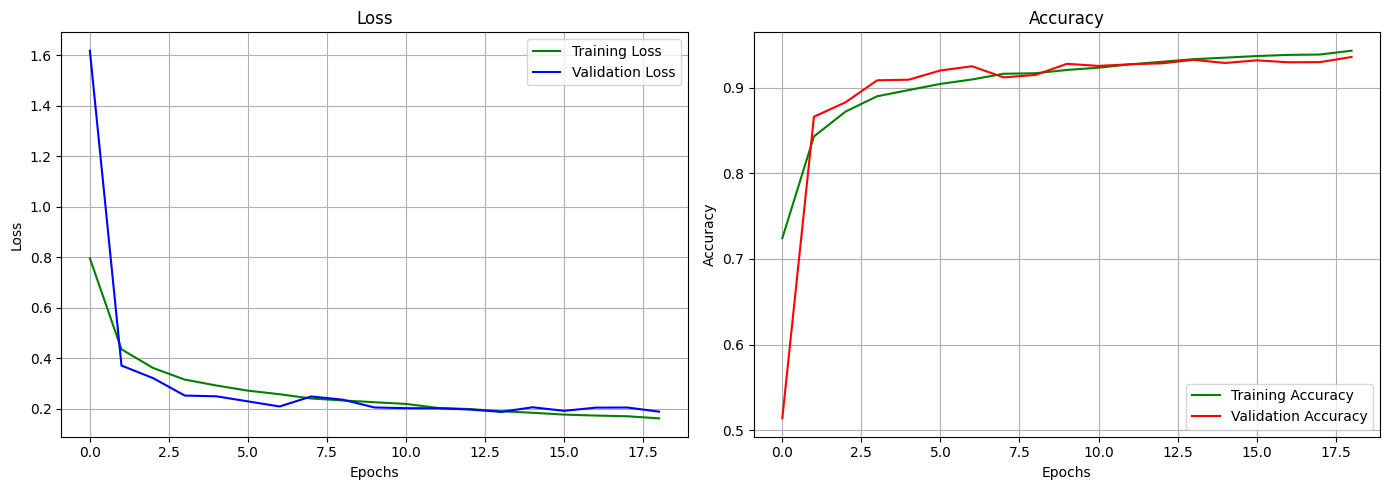

In [27]:
visualize_training_history(history_v3)

# CNN model based on VGG16 model 

- **Step 1.** Loading the data for the VGG16 based model:

In [28]:
(X_train_vgg16, y_train_vgg16), (X_test_vgg16, y_test_vgg16) = datasets.fashion_mnist.load_data()

- **Step 2.** Data preprocessing. Changing dimension from (28, 28, 1) to (28, 28, 3) because VGG16 is expecting image with 3 channels (RGB):

In [29]:
X_train_vgg16 = tf.image.grayscale_to_rgb(tf.expand_dims(X_train_vgg16, axis=-1))
X_test_vgg16 = tf.image.grayscale_to_rgb(tf.expand_dims(X_test_vgg16, axis=-1))

- **Step 3.** Resizing images to match VGG16 input shape (150, 150, 3)

In [30]:
X_train_vgg16 = tf.image.resize(X_train_vgg16, (32, 32))  # (150, 150, 3)
X_test_vgg16 = tf.image.resize(X_test_vgg16, (32, 32))  # (150, 150, 3)

- **Step 4.** Normalizing pixel values to range [0, 1]

In [31]:
X_train_vgg16 = X_train_vgg16 / 255.0
X_test_vgg16 = X_test_vgg16 / 255.0

- **Step 5.** One-hot encoding the labels for categorical cross-entropy

In [32]:
y_train_vgg16 = to_categorical(y_train_vgg16, 10)
y_test_vgg16 = to_categorical(y_test_vgg16, 10)

- **Step 6.** Loading VGG16 as a base and freezing all layers in VGG16 to use it as a feature extractor:

In [33]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

vgg_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


- **Step 7.** Creating and compiling the model:

In [34]:
model_v6 = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")],
    name="V6_VGG_based_1")

model_v6.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model_v6.summary()

Model: "V6_VGG_based_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

- **Step 8.** Training the model. I"ll use 20 epochs, batch size 64 and splitting the training data into training (80%) and validation (20%): 

In [35]:
history_v6 = model_v6.fit(X_train_vgg16, y_train_vgg16, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6729 - loss: 0.9392 - val_accuracy: 0.8185 - val_loss: 0.4859
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8172 - loss: 0.5028 - val_accuracy: 0.8368 - val_loss: 0.4367
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8363 - loss: 0.4516 - val_accuracy: 0.8477 - val_loss: 0.4110
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8443 - loss: 0.4251 - val_accuracy: 0.8493 - val_loss: 0.4013
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8445 - loss: 0.4140 - val_accuracy: 0.8479 - val_loss: 0.4047
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8544 - loss: 0.3982 - val_accuracy: 0.8587 - val_loss: 0.3825
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8632 - loss: 0.3778 - val_accuracy: 0.8607 - val_loss: 0.3781
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8606 - loss: 0.3760 - val_accuracy: 

In [36]:
model_v6.save(f"{model_v6.name}.keras")

- **Step 9.** Evaluating the model progress in Validation Loss and Validation Accuracy, which tracks the capability of model to generalize to unseen data:

In [37]:
test_loss, test_acc = model_v6.evaluate(X_test_vgg16, y_test_vgg16)
print(f"\nValidation Accuracy of the model '{model_v6.name}' : {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8738 - loss: 0.3456

Validation Accuracy of the model 'V6_VGG_based_1' : 0.8725


- **Step 10.** Visualizing the training history:

In [38]:
histories[model_v6.name] = history_v6

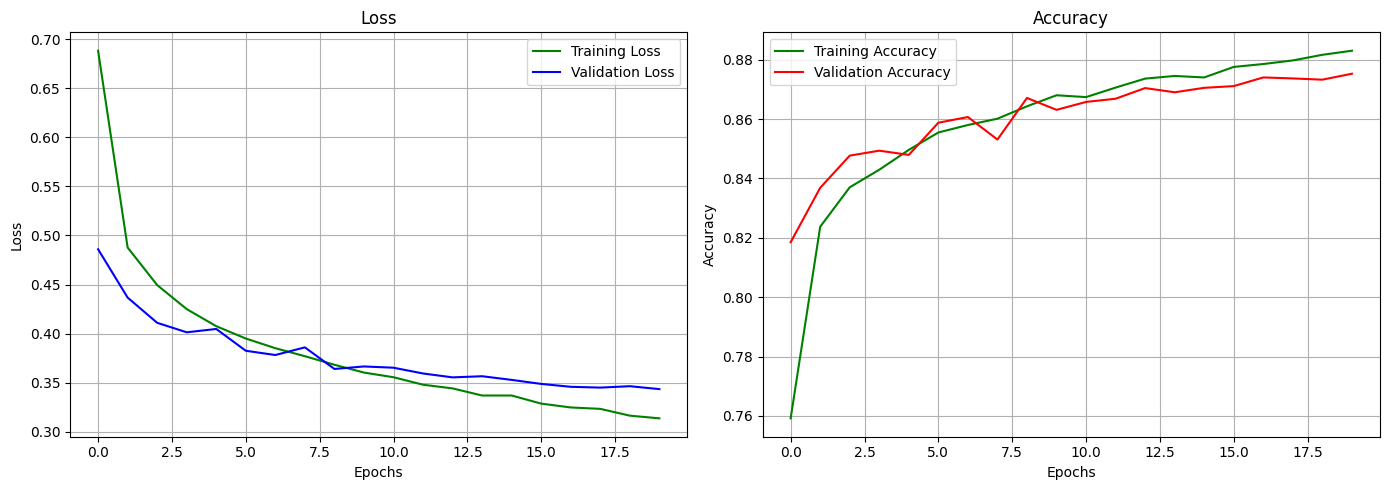

In [39]:
visualize_training_history(history_v6)

## Multi-layer Simple NN Model from previous practice with the best hyperparameters set:

In [40]:
model_v5 = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")],
    name="V5_model_2HL_DropOut_Adam")

model_v5.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_v5 = model_v5.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7245 - loss: 0.7865 - val_accuracy: 0.8337 - val_loss: 0.4590
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8498 - loss: 0.4198 - val_accuracy: 0.8556 - val_loss: 0.3913
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8686 - loss: 0.3673 - val_accuracy: 0.8702 - val_loss: 0.3595
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8748 - loss: 0.3394 - val_accuracy: 0.8706 - val_loss: 0.3597
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8798 - loss: 0.3249 - val_accuracy: 0.8823 - val_loss: 0.3257
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8835 - loss: 0.3114 - val_accuracy: 0.8834 - val_loss: 0.3266
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8912 - loss: 0.2917 - val_accuracy: 0.8842 - val_loss: 0.3208
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8973 - loss: 0.2786 - val_accuracy: 0.

In [41]:
histories[model_v5.name] = history_v5

# Comparison of all Models based on their results

This task was made in order to practice and compare various Convolutional Neural Network models and Multi-layer Neural Network model created before. I  used popular fashion MNIST dataset, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

The bar chart below compares the five models according to their Train Accuracy, Validation Accuracy, Train Loss, and Validation Loss.

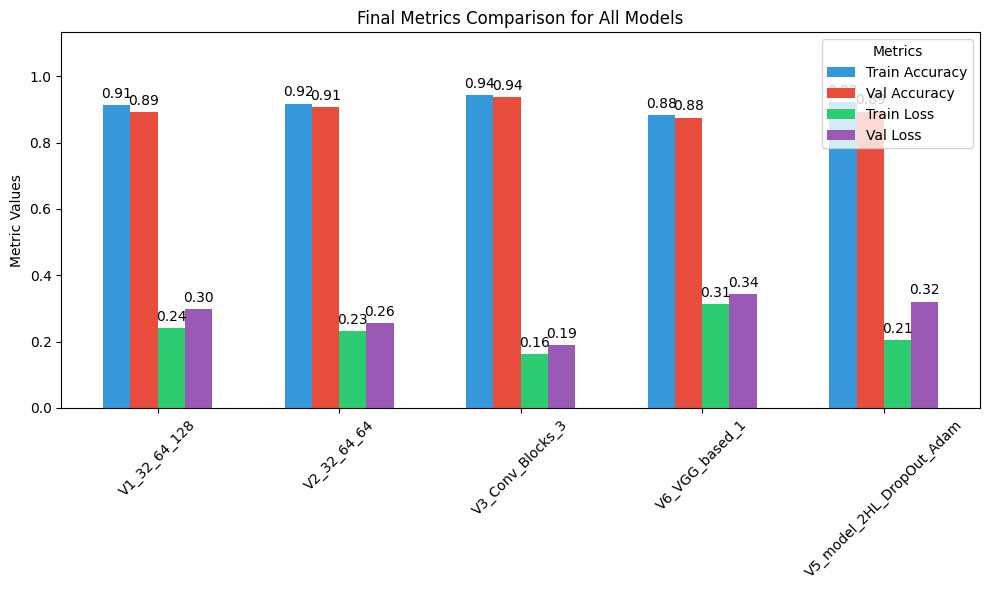

In [42]:
plot_combined_bars(histories)

--#

### **1. V1_32_64_128**
- **Train Accuracy**: 0.92  
- **Validation Accuracy**: 0.90  
- **Train Loss**: 0.22  
- **Validation Loss**: 0.31  

**Strengths**:
- Good training accuracy, showing that it can effectively learn from the data.
  
**Weaknesses**:
- A noticeable difference between training and validation loss suggests slight overfit#ting. 

---

### **2. V2_32_64_64 (Improved Basic)**
- **Train Accuracy**: 0.91  
- **Validation Accuracy**: 0.91  
- **Train Loss**: 0.25  
- **Validation Loss**: 0.26  

**Strengths**:
- Balanced accuracy between training and validation, showing minimal overfitting.  
- The improved architecture with reduced complexity (fewer filters in the last Conv2D) provides robust generalization.  

**Weaknesses**:
- Slightly lower training accuracy compared to V1, but it #generalizes better.  

---

### **3. V3_Conv_Blocks_3**
- **Train Accuracy**: 0.96  
- **Validation Accuracy**: 0.94  
- **Train Loss**: 0.12  
- **Validation Loss**: 0.18  

**Strengths**:
- Excellent training and validation accuracy with very low losses, showing strong performance.  
- Advanced architecture with Batch Normalization and Dropout helps prevent overfitting while improving learning.  

**Weaknesses**:
- More computationally expensive due to its complexity (addi#tional Conv2D layers and dropout).  

---

### **4. V6_VGG_based_1**
- **Train Accuracy**: 0.89  
- **Validation Accuracy**: 0.87  
- **Train Loss**: 0.31  
- **Validation Loss**: 0.35  

**Strengths**:
- Leverages pre-trained VGG16 for feature extraction.  
- Moderate performance despite limited training on a small dataset (Fashion MNIST).  

**Weaknesses**:
- Lower accuracy compared to custom models (e.g., V3).  
- May require f#ine-tuning or augmentation to improve performance.  

---

### **5. V5_model_2HL_DropOut_Adam**
- **Train Accuracy**: 0.89  
- **Validation Accuracy**: 0.89  
- **Train Loss**: 0.21  
- **Validation Loss**: 0.32  

**Strengths**:
- Simple multi-layer neural network achieving good results without convolutional layers.  
- Best among non-convolutional architectures.  

**Weaknesses**:
- Cannot compete with convolutional models like V3 in peoice.
- **V6_VGG_based_1** can be explored further by fine-tuning or adding layers to improve accuracy.

## **Overall Observations**
1. **Best Model (Performance)**: **V3_Conv_Blocks_3**
   - Highest accuracy and lowest loss, demonstrating excellent performance.
   - Recommended for tasks where computational resources are available.

2. **Best Model (Efficiency)**: **V2_32_64_64**
   - Balanced accuracy and loss with a simpler architecture.
   - Recommended for tasks with limited computational resources.

3. **Pre-trained Model**: **V6_VGG_based_1**
   - Pre-trained models like VGG16 are ideal when transfer learning is required but may underperform without fine-tuning.

4. **Baseline Model**: **V1_32_64_128**
   - Good starting point but prone to overfitting without optimizations.

5. **Fully Connected Model**: **V5_model_2HL_DropOut_Adam**
   - Effective for simpler datasets but outperformed by CNN-based models.

# **Conclusion**
- **V3_Conv_Blocks_3** is the most effective model, showcasing the value of advanced architecture.
- **V2_32_64_64** provides a strong balance between performance and simplicity, making it a practical choice.
- **V6_VGG_based_1** can be explored further by fine-tuning or adding layers to improve accuracy.